In [1]:
from importlib import import_module

In [2]:
from pyiron_workflow import Workflow, function_node

In [3]:
import json

In [4]:
from inspect import isfunction

In [5]:
def create_input_nodes(nodes_dict, edges_lst):
    node_conversion_dict = {
        ed['source']: ed['targetHandle']
        for ed in edges_lst if ed["sourceHandle"] is None
    }
    nodes_to_create_dict = {
        v: nodes_dict[k] 
        for k, v in node_conversion_dict.items()
    }
    return nodes_to_create_dict, node_conversion_dict

In [6]:
def set_input_nodes(workflow, nodes_to_create_dict):
    for k, v in nodes_to_create_dict.items():
        workflow.__setattr__(k, v)
    return workflow

In [7]:
def get_source_handles(edges_lst):
    source_handle_dict = {}
    for ed in edges_lst: 
        if ed['source'] not in source_handle_dict.keys():
            source_handle_dict[ed['source']] = [ed['sourceHandle']]
        else:
            source_handle_dict[ed['source']].append(ed['sourceHandle'])
    return source_handle_dict

In [8]:
def get_function_nodes(nodes_dict):
    function_dict = {}
    for k, v in nodes_dict.items():
        if isfunction(v):
            if k in source_handle_dict.keys():
                function_dict[k] = {"node_function": v, "output_labels": source_handle_dict[k]}
            else:
                function_dict[k] = {"node_function": v}
    return function_dict

In [9]:
def get_kwargs(lst):
    return {t['targetHandle']: {'source': t['source'], 'sourceHandle': t['sourceHandle']} for t in lst}

In [10]:
def group_edges(edges_lst):
    edges_sorted_lst = sorted(edges_lst, key=lambda x: x['target'], reverse=True)     
    total_dict = {}
    tmp_lst = []
    target_id = edges_sorted_lst[0]['target'] 
    for ed in edges_sorted_lst:
        if target_id == ed["target"]:
            tmp_lst.append(ed)
        else:
            total_dict[target_id] = get_kwargs(lst=tmp_lst)
            target_id = ed["target"]
            tmp_lst = [ed]
    total_dict[target_id] = get_kwargs(lst=tmp_lst)
    return total_dict

In [11]:
def build_workflow(workflow, function_dict, total_dict, node_conversion_dict):
    for k, v in function_dict.items():
        kwargs_link_dict = total_dict[k]
        kwargs_dict = {}
        for kw, vw in kwargs_link_dict.items():
            if vw["source"] in node_conversion_dict.keys():
                kwargs_dict[kw] = workflow.__getattribute__(node_conversion_dict[vw["source"]])
            else: 
                kwargs_dict[kw] = workflow.__getattr__("tmp_" + str(vw["source"])).__getattribute__("outputs").__getattr__(vw['sourceHandle'])
        v.update(kwargs_dict)
        print(v)
        workflow.__setattr__("tmp_" + str(k), function_node(**v, validate_output_labels=False))
    return workflow, "tmp_" + str(k)

In [12]:
file_name = "workflow.json"

In [13]:
with open(file_name, "r") as f:
    content = json.load(f)

In [14]:
edges_lst = content["edges"]

In [15]:
nodes_new_dict = {}
for k, v in content["nodes"].items():
    if isinstance(v, str) and "." in v:
        p, m = v.rsplit('.', 1)
        mod = import_module(p)
        nodes_new_dict[int(k)] = getattr(mod, m)
    else:
        nodes_new_dict[int(k)] = v

In [16]:
nodes_new_dict

{0: <function simple_workflow.add_x_and_y(x, y)>,
 1: <function simple_workflow.add_x_and_y_and_z(x, y, z)>,
 2: 1,
 3: 2}

In [17]:
wf = Workflow("my_workflow")

In [18]:
nodes_to_create_dict, node_conversion_dict = create_input_nodes(nodes_dict=nodes_new_dict, edges_lst=edges_lst)
wf = set_input_nodes(workflow=wf, nodes_to_create_dict=nodes_to_create_dict)

In [19]:
source_handle_dict = get_source_handles(edges_lst=edges_lst)
function_dict = get_function_nodes(nodes_dict=nodes_new_dict)
total_dict = group_edges(edges_lst=edges_lst)

In [20]:
wf, label = build_workflow(
    workflow=wf, 
    function_dict=function_dict, 
    total_dict=total_dict, 
    node_conversion_dict=node_conversion_dict,
)

{'node_function': <function add_x_and_y at 0x7a94a0dea660>, 'output_labels': ['x', 'y', 'z'], 'x': 1, 'y': 2}
{'node_function': <function add_x_and_y_and_z at 0x7a94a0dea700>, 'x': <pyiron_workflow.mixin.injection.OutputDataWithInjection object at 0x7a94a0df9100>, 'y': <pyiron_workflow.mixin.injection.OutputDataWithInjection object at 0x7a94ac254860>, 'z': <pyiron_workflow.mixin.injection.OutputDataWithInjection object at 0x7a94a0df9c40>}


In [21]:
wf.__getattr__(label).pull()

'xyz'

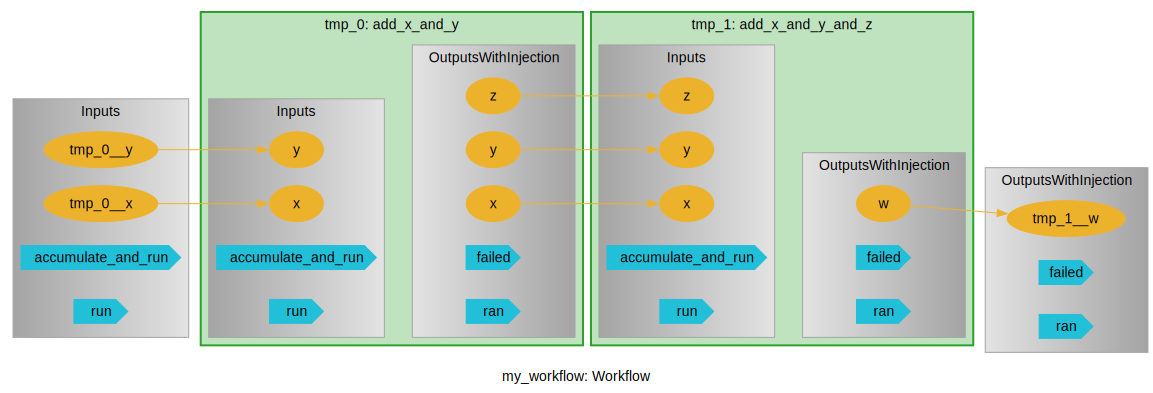

In [22]:
wf.draw()